In [2]:
! pip install ultralytics
! pip install hydra-core

! rm -r machine-perception machine_perception
! git clone https://github.com/Ansever/machine-perception.git
! git clone https://github.com/facebookresearch/sam2.git machine-perception/src/machine_perception/models/facebook/sam2
! cp -r machine-perception/src/machine_perception .

Cloning into 'machine-perception'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 145 (delta 62), reused 120 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 21.32 MiB | 20.38 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Cloning into 'machine-perception/src/machine_perception/models/facebook/sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [ ]:
! mkdir output_masks
! mkdir output_masks/yolo
! mkdir output_masks/sam
! mkdir output_masks/stm
! mkdir output_masks/stmfinetune

! mkdir sam2
! cp /kaggle/working/machine-perception/resources/sam/* sam2
! cp /kaggle/working/machine-perception/resources/sam/* /kaggle/working/machine_perception/models/facebook/sam2/sam2

# Download weights
! wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11x-seg.pt -P /kaggle/working/machine-perception/resources/yolo
! wget https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt -P sam2
! wget -O /kaggle/working/machine-perception/resources/stm/STM_weights.pth "https://www.dropbox.com/s/mtfxdr93xc3q55i/STM_weights.pth?dl=1"

In [1]:
from typing import Callable

from pathlib import Path
import os
import threading
import json
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("/kaggle/working/machine_perception/models/facebook/sam2")

import torch
from ultralytics import YOLO
from machine_perception.experiments.predictor import (
    SamVideoPredictor,
    StmVideoPredictor,
    YoloVideoPredictor,
)
from machine_perception.models.sam2 import SAM2
from machine_perception.models.stm.model import STM, load_stm_state_dict
from machine_perception.utils import Instance

In [2]:
def resize_image(src_path: str | Path, dst_path: str | Path):
    try:
        with Image.open(src_path) as img:
            img = img.convert("RGB")
            img = img.resize((384, 384))
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            img.save(dst_path)
    except Exception as e:
        print(f"Failed to process {src_path}: {e}")

def resize_mask(src_path: str | Path, dst_path: str | Path):
    try:
        with Image.open(src_path) as img_pil:
            img_pil = img_pil.convert("P")
            palette = img_pil.palette

            img = np.array(img_pil)
            # print(f"{np.unique(img) = }")
            img = cv2.resize(img, (384, 384), interpolation=cv2.INTER_NEAREST)
            # print(f"{np.unique(img) = }")
            # raise ValueError('Lolkek')
            img_pil = Image.fromarray(img, mode="P")
            img_pil.putpalette(palette)
            
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            img_pil.save(dst_path)
    except Exception as e:
        print(f"Failed to process {src_path}: {e}")

def resize_in_directory(
    resize_func: Callable[str | Path, str | Path],
    input_dir, 
    output_dir, 
    max_threads: int | None = None
):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    tasks = []

    # Collect image processing tasks
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                src_path = os.path.join(root, file)
                relative_path = os.path.relpath(src_path, input_dir)
                dst_path = os.path.join(output_dir, relative_path)
                tasks.append((src_path, dst_path))

    # Process using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(resize_func, src, dst) for src, dst in tasks]
        for future in futures:
            future.result()  # Wait for all threads to complete

def resize_dataset(data_path: str | Path, new_data_path: str | Path):
    data_path = Path(data_path)
    new_data_path = Path(new_data_path)

    # resize_in_directory(resize_image, data_path / "JPEGImages", new_data_path / "JPEGImages")
    resize_in_directory(resize_mask, data_path / "Annotations", new_data_path / "Annotations")

In [3]:
# resize_dataset("/kaggle/input/mose-subset/data_subset/test", Path().resolve() / "test_resized")

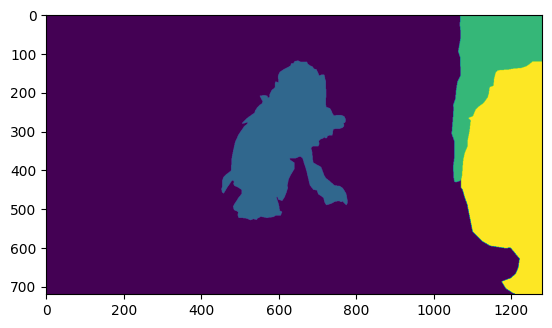

In [4]:
# mask = np.array(Image.open("/kaggle/working/test_resized/Annotations/0b787263/00000.png"))
mask = np.array(Image.open("/kaggle/input/mose-subset/data_subset/test/Annotations/0b787263/00000.png"))
plt.imshow(mask)

In [5]:
# def calculate_iou(gt_mask, pred_mask):
#     """
#     Calculate Intersection over Union (IoU) for a single pair of predicted and ground truth masks.

#     Args:
#         pred_mask (np.ndarray): Binary predicted mask (bool or 0/1).
#         gt_mask (np.ndarray): Binary ground truth mask (bool or 0/1).

#     Returns:
#         float: IoU score.
#     """
#     intersection = np.logical_and(pred_mask, gt_mask).sum()
#     union = np.logical_or(pred_mask, gt_mask).sum()
#     iou = intersection / union if union != 0 else 0
#     return iou

def compute_iou(gt_mask, pred_mask, num_objects):
    ious = []
    for obj_id in range(1, num_objects + 1):
        gt_obj = (gt_mask == obj_id)
        pred_obj = (pred_mask == obj_id)
        intersection = np.logical_and(gt_obj, pred_obj).sum()
        union = np.logical_or(gt_obj, pred_obj).sum()
        if union > 0:
            ious.append(intersection / union)
    return ious  # list of IoUs per object

def extract_boundary(mask, dilation_ratio=0.02):
    # print(f"{mask.shape = }")
    h, w = mask.shape
    diag = np.sqrt(h ** 2 + w ** 2)
    dilation = max(1, int(round(dilation_ratio * diag)))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilation*2+1, dilation*2+1))
    dilated = cv2.dilate(mask.astype(np.uint8), kernel)
    eroded = cv2.erode(mask.astype(np.uint8), kernel)
    boundary = dilated - eroded
    return boundary

def compute_boundary_fscore(gt_mask, pred_mask, num_objects, tolerance=2):
    f_scores = []
    for obj_id in range(1, num_objects + 1):
        gt_obj = (gt_mask == obj_id)
        pred_obj = (pred_mask == obj_id)
        
        gt_boundary = extract_boundary(gt_obj)
        pred_boundary = extract_boundary(pred_obj)

        # Convert to binary
        gt_b = gt_boundary > 0
        pred_b = pred_boundary > 0

        # Compute precision and recall with tolerance
        gt_dil = cv2.dilate(gt_b.astype(np.uint8), np.ones((2*tolerance+1, 2*tolerance+1)))
        pred_dil = cv2.dilate(pred_b.astype(np.uint8), np.ones((2*tolerance+1, 2*tolerance+1)))

        matched_gt = np.logical_and(pred_b, gt_dil).sum()
        matched_pred = np.logical_and(gt_b, pred_dil).sum()

        n_pred = pred_b.sum()
        n_gt = gt_b.sum()

        if n_pred + n_gt == 0:
            f_scores.append(1.0)
        elif n_pred == 0 or n_gt == 0:
            f_scores.append(0.0)
        else:
            precision = matched_pred / n_pred
            recall = matched_gt / n_gt
            if precision + recall == 0:
                f_scores.append(0.0)
            else:
                f_scores.append(2 * precision * recall / (precision + recall))
    return f_scores  # list of F-scores per object

In [14]:
all_results = evaluate_predictions(
    "/kaggle/working/test_resized/Annotations", 
    "/kaggle/working/output_masks/stmfinetune",
    "/kaggle/input/mose-subset/data_subset/meta_test_split.json",
)

with open("stmfinetune_metrics.json", "w") as f:
    json.dump(all_results, f, indent=4)

# all_results = evaluate_predictions(
#     "/kaggle/input/mose-subset/data_subset/test/Annotations", 
#     "/kaggle/working/output_masks/yolo",
#     "/kaggle/input/mose-subset/data_subset/meta_test_split.json",
# )
# ! touch /kaggle/working/machine_perception/models/facebook/__init__.py
# ! touch /kaggle/working/machine_perception/models/facebook/sam2/__init__.py

32it [00:28,  1.97it/s]

Failed on ba538072
Failed on 2f477d05


76it [01:02,  1.21it/s]


In [15]:
all_results

{'f415f9ad': {'iou': 0.021739130434782608, 'boundary': 0.021739130434782608},
 'f9884439': {'iou': 0.020337455919642117, 'boundary': 0.04992521923542184},
 '34504f63': {'iou': 0.07110651493643919, 'boundary': 0.18277531027897445},
 '4cb11a5f': {'iou': 0.0625, 'boundary': 0.0625},
 'fd5c5cfb': {'iou': 0.35680861662626767, 'boundary': 0.6214701408165653},
 'c062f4d7': {'iou': 0.13366051631093112, 'boundary': 0.2247011943072727},
 '5d2316f6': {'iou': 0.07638083699844159, 'boundary': 0.1807638639648442},
 '6adad2f7': {'iou': 0.12988492263596388, 'boundary': 0.30449227109060256},
 '10552818': {'iou': 0.015585292952874915, 'boundary': 0.0763460963987531},
 'b8e1ec26': {'iou': 0.2197404655893586, 'boundary': 0.24743173019014025},
 'a7c21e95': {'iou': 0.18376379752959632, 'boundary': 0.23537532250607862},
 'a7b05677': {'iou': 0.03125, 'boundary': 0.03125},
 '51586b36': {'iou': 0.03225806451612903, 'boundary': 0.03225806451612903},
 '26ed56e6': {'iou': 0.1907884593729787, 'boundary': 0.46497194

In [18]:
def aggregate_metrics(metrics):
    all_ious = [data["iou"] for _, data in metrics.items()]
    all_boundaries = [data["boundary"] for _, data in metrics.items()]

    print(f"{np.mean(all_ious) = }")
    print(f"{np.mean(all_boundaries) = }")


for fpath in ["sam_metrics.json", "yolo_metrics.json", "stm_metrics.json", "stmfinetune_metrics.json"]:
    print(f"{fpath = }")
    with open(fpath, "r") as f:
        metrics = json.load(f)
        aggregate_metrics(metrics)

fpath = 'sam_metrics.json'
np.mean(all_ious) = 0.6394641310236615
np.mean(all_boundaries) = 0.8047041830788143
fpath = 'yolo_metrics.json'
np.mean(all_ious) = 0.043124810940250446
np.mean(all_boundaries) = 0.09973906220623152
fpath = 'stm_metrics.json'
np.mean(all_ious) = 0.05833216661532116
np.mean(all_boundaries) = 0.09196088793433432
fpath = 'stmfinetune_metrics.json'
np.mean(all_ious) = 0.12270469327565414
np.mean(all_boundaries) = 0.18879543219978062


In [8]:
def read_mask(path: str | Path):
    mask_pil = Image.open(path).convert("P")
    mask = np.array(mask_pil, dtype=np.uint8)
    return mask


def compute_metrics(
    true_mask_paths: list[str | Path], pred_mask_paths: list[str | Path], num_objects: int
):
    assert len(true_mask_paths) == len(pred_mask_paths)
    iou_scores, boundary_scores = [], []
    for true_mask_path, pred_mask_path in zip(true_mask_paths, pred_mask_paths):
        true_mask = read_mask(true_mask_path)
        pred_mask = read_mask(pred_mask_path)
        num_objects = np.max(true_mask)
        iou_scores.extend(compute_iou(true_mask, pred_mask, num_objects))
        # print(iou_scores)
        boundary_scores.extend(compute_boundary_fscore(true_mask, pred_mask, num_objects))
    return {
        "iou": np.mean(iou_scores),
        "boundary": np.mean(boundary_scores)
    }


def evaluate_predictions(annot_true_dir: str | Path, annot_pred_dir: str | Path, meta_path: str | Path):
    annot_true_dir = Path(annot_true_dir)
    annot_pred_dir = Path(annot_pred_dir)
    all_metrics = {}
    with open(meta_path, "r") as f:
        metadata = json.load(f)["videos"]
    for video_id in tqdm.tqdm(map(lambda x: x.stem, annot_pred_dir.glob("*"))):
        try:
            true_mask_paths = list((annot_true_dir / video_id).glob("*"))
            pred_mask_paths = list((annot_pred_dir / video_id).glob("*"))
            metrics = compute_metrics(
                true_mask_paths, 
                pred_mask_paths, 
                len(metadata[video_id]["objects"])
            )
            all_metrics[video_id] = metrics
            # if len(all_metrics) == 5:
            #     break
            # print(all_metrics)
        except Exception:
            print(f"Failed on {video_id}")
    return all_metrics

In [6]:
def run_sam(instance: Instance, device: str):
    base_dir = Path().resolve() / "sam2"

    # CHECKPOINT = base_dir / "resources" / "sam" / "sam2.1_hiera_large.pt"
    # CONFIG = base_dir / "resources" / "sam" / "sam2.1_hiera_l.yaml"
    # CHECKPOINT = base_dir / "resources" / "sam" / "sam2.1_hiera_small.pt"
    # CONFIG = base_dir / "resources" / "sam" / "sam2.1_hiera_s.yaml"
    CHECKPOINT = base_dir / "sam2.1_hiera_large.pt"
    CONFIG = "sam2.1_hiera_l.yaml"

    sam = SAM2(config=str(CONFIG), checkpoint=CHECKPOINT, device=device)
    sam_predictor = SamVideoPredictor(sam)
    sam_predictor.predict_video(instance, f"output_masks/sam/{instance['id_']}")


def run_stm(instance: Instance, device: str):
    # WEIGHTS_PATH = Path("/kaggle/working/machine-perception") / "resources" / "stm" / "STM_weights.pth"

    WEIGHTS_PATH = Path("/kaggle/input/stm-epoch-79/pytorch/default/1/stm_epoch_79.pth")
    
    stm = STM()
    stm.load_state_dict(load_stm_state_dict(WEIGHTS_PATH))
    stm.to(device)

    stm_predictor = StmVideoPredictor(
        stm, k=11, memory_every=5, memory_number=None, device=device
    )
    stm_predictor.predict_video(instance, f"output_masks/stmfinetune/{instance['id_']}")


def run_yolo(instance: Instance, device: str):
    model_path = Path("/kaggle/working/machine-perception") / "resources" / "yolo" / "yolo11x-seg.pt"
    yolo = YOLO(model=model_path)
    yolo_predictor = YoloVideoPredictor(yolo)
    yolo_predictor.predict_video(instance, f"output_masks/yolo/{instance['id_']}")

In [7]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

In [8]:
with open("/kaggle/input/mose-subset/data_subset/meta_test_split.json", "r") as f:
    metadata = json.load(f)["videos"]

instances = []
for video_id, video_meta in metadata.items():
    # instances.append({
    #     "id_": video_id,
    #     "frames_dir": f"/kaggle/working/test_resized/JPEGImages/{video_id}",
    #     "input_mask_path": f"/kaggle/working/test_resized/Annotations/{video_id}/00000.png",
    #     "n_frames": video_meta["length"],
    #     "n_objects": len(video_meta["objects"]),
    #     "frame_height": 384,
    #     "frame_width": 384,
    # })
    instances.append({
        "id_": video_id,
        "frames_dir": f"/kaggle/input/mose-subset/data_subset/test/JPEGImages/{video_id}",
        "input_mask_path": f"/kaggle/input/mose-subset/data_subset/test/Annotations/{video_id}/00000.png",
        "n_frames": video_meta["length"],
        "n_objects": len(video_meta["objects"]),
        "frame_height": video_meta["width"],
        "frame_width": video_meta["height"],
    })

In [6]:
def frames_to_video(
    frames: list[np.ndarray] | np.ndarray, output_file: str | Path, frame_rate: int = 30
):
    if len(frames) == 0:
        raise ValueError("frames are empty")
    frame_size = (frames[0].shape[1], frames[0].shape[0])
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out = cv2.VideoWriter(output_file, fourcc, frame_rate, frame_size)

    for frame in frames:
        out.write(frame[:, :, [2, 1, 0]])
    out.release()

def create_video_frames(
    frames_dir: str | Path, masks_dir: str | Path, mask_alpha: float = 0.8
):
    frames_dir = Path(frames_dir)
    masks_dir = Path(masks_dir)

    final_frames = []
    frame_paths = sorted(list(frames_dir.glob("*")))
    for frame_path in frame_paths:
        mask_path = masks_dir / f"{frame_path.stem}.png"
        frame = np.array(Image.open(frame_path))
        try:
            mask = np.array(Image.open(mask_path).convert("RGB"))
        except Exception:
            break

        final_frame = (frame * (1 - mask_alpha) + mask * mask_alpha).astype(np.uint8)
        final_frames.append(final_frame)

    return final_frames

In [7]:
video_id = "83b7c53c"

final_frames = create_video_frames(
    f"/kaggle/input/mose-subset/data_subset/test/JPEGImages/{video_id}", 
    f"/kaggle/input/mose-subset/data_subset/test/Annotations/{video_id}", 
    mask_alpha=0.6,
)
frames_to_video(final_frames, f"true_video.avi", frame_rate=30)

In [12]:
model = "yolo"
video_id = "83b7c53c"

final_frames = create_video_frames(
    f"/kaggle/input/mose-subset/data_subset/test/JPEGImages/{video_id}", 
    f"/kaggle/working/output_masks/{model}/{video_id}", 
    mask_alpha=0.6,
)
frames_to_video(final_frames, f"{model}_video.avi", frame_rate=30)

In [10]:
import tqdm

failed = 0
for instance in tqdm.tqdm(instances):
    # if instance["id_"] != "83b7c53c":
    #     continue
    try:
        # run_sam(instance, DEVICE)
        run_yolo(instance, DEVICE)
    except Exception:
        print(f"Failed on {instance}")
        failed += 1

  0%|          | 0/76 [00:00<?, ?it/s]


0: 384x640 2 birds, 62.8ms
Speed: 5.9ms preprocess, 62.8ms inference, 133.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.9ms
Speed: 1.8ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 33.7ms
Speed: 1.6ms preprocess, 33.7ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 33.3ms
Speed: 1.6ms preprocess, 33.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 33.3ms
Speed: 1.6ms preprocess, 33.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cat, 1 bear, 32.9ms
Speed: 1.8ms preprocess, 32.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bird, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 31.0ms
Speed: 1.6ms preprocess, 31.0ms inference, 2.4ms postprocess per image at shape (1, 3

100%|██████████| 76/76 [00:05<00:00, 13.80it/s]
